# Rigid Rotator Variational Solution...

## $\Phi$:

For $\phi$ we simply use the analytic solution

$-m^2 \Phi(\phi)= \frac{\partial^2}{\partial^2\phi} \Phi(\phi)$

which is straightforward eigenvalue-eigenvector problem with solutions

$\Phi(\phi) = A_me^{im\phi}\quad \mathrm{and}\quad A_{-m}e^{-im\phi}$.

Applying boundary conditions, $\Phi(\phi+2\pi) = \Phi(\phi)$ yields the quantization

$m=0,\pm 1, \pm 2, ...$

Thus we can write

$\Phi(\phi) = Ae^{im\phi} \quad m=0,\pm 1, \pm 2, ...$.

Normalization yields $A=\frac{1}{\sqrt{2\pi}}$.

## $\Theta$:

We start with the side of the equation with $\theta$ dependence equal to $m^2$:

$m^2 = \frac{\sin\theta}{\Theta(\theta)}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)+\beta\sin^2\theta$.

The goal now is to rearrange this to an eigenvalue equation.  Start by substracting $\beta\sin^2\theta$ from both sides:

$m^2 - \beta\sin^2\theta = \frac{\sin\theta}{\Theta(\theta)}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$,

now multiply both sides of the equation by $\Theta(\theta)$

$\left(m^2 - \beta\sin^2\theta\right)\Theta(\theta) = \sin\theta\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$.

This resembles an eigenvalue equation except that $\beta$ is multiplied by $\sin^2\theta$.  So we divide both sides of the equation by $\sin^2\theta$ to yield:

$\left(\frac{m^2}{\sin^2\theta} - \beta\right)\Theta(\theta) =\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$

We now recognize that $m = 0, \pm 1, \pm 2,  ...$ as dictated by the solutions above for $\phi$.  Thus we know something about $m$ but nothing about $\beta$.  We will solve this for $m=0$ and leave any other solution for excercise.

$\Rightarrow  \beta\Theta(\theta) =-\frac{1}{\sin\theta}\frac{\partial}{\partial\theta}\left(\sin\theta\frac{\partial}{\partial\theta}\right)\Theta(\theta)$

This is an eigenvalue equation that we can apply the variational principle to.  We must now devise a basis set that is defined over domain $0 < \theta < \pi$ and the derivative of the functions must be zero at the boundaries (why?).

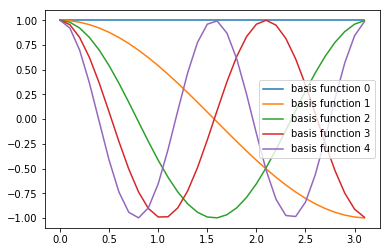

In [280]:
# cos basis function in theta
def theta_basis(theta,i):
    return np.cos(i*theta)
thetaVals=np.arange(0,np.pi,0.1)
for i in range(5):
    label = "basis function " + str(i)
    plt.plot(thetaVals,theta_basis(thetaVals,i),label=label)
plt.legend()

In [358]:
# code to perform Variational principle solution to expansion of wavefunctions in a gaussian basis to K+V Hamiltonian in 1D
from scipy import integrate
import numpy as np

hbar = 1.0
r0 = 1.0
mu = 1.0
Hconst = -hbar**2/(2*mu*r0)
Hconst = 1.0

# overlap integrand
def overlap_integrand(theta,basis_function,i):
    return basis_function(theta,i)**2*np.sin(theta)
# S integrand
def S_integrand(theta,basis_function,i,j):
    return basis_function(theta,i)*basis_function(theta,j)*np.sin(theta)

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def basis_rigid_rotator(N,basis_function,H_integrand,thetaVals=np.arange(0,np.pi,0.1)):
    S = np.zeros((N,N),dtype=np.float64)   # basis function overlap matrix
    H = np.zeros((N,N),dtype=np.float64)   # Hamiltonian matrix, Hij = <Si|H|Sj>
    
    # normalize basis functions
    norm = np.empty(N,dtype=float)
    for i in range(N):
        norm[i] = np.sqrt(integrate.quad(overlap_integrand,0,np.pi,args=(basis_function,i))[0])    
        # populate the basis function overlap, S, and Hamiltonian, H, matrices
    for i in range(N):
        for j in range(N):
            normConst = (norm[i]*norm[j])**(-1)
            # basis function overlap matrix element
            S[i,j] = normConst*integrate.quad(S_integrand,0,np.pi,args=(basis_function,i,j))[0]
            # Hamiltonian matrix element
            H[i,j] = Hconst*normConst*integrate.quad(H_integrand,0,np.pi,args=(i,j))[0]
            # symmetrize
            #S[j,i] = S[i,j]
            #H[j,i] = H[i,j]
            
    # finalize the S^-1*H matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these in ascending order of eigenvalues
    idx = H_eig_val.argsort()   
    E = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]
    
    nTheta = thetaVals.size
    psi = np.zeros((nTheta,N),dtype=np.float64)
    # generate psis from coefficients
    for A in range(N):
        for i in range(N):
            wave = H_eig_vec[i,A]/norm[i]*theta_basis(thetaVals,i)
            psi[:,A] = psi[:,A] + wave
        # normalize the wavefunctions
        psi2 = np.power(psi[:,A],2)
        normPsi = integrate.simps(psi2*np.sin(thetaVals),thetaVals)
        psi[:,A] /= np.sqrt(normPsi)
    return E, psi, thetaVals, S, H

# plot of some of the Legendre polynomials and variational wavefunctions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import lpmv
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
def plot_rigid_rotator_wavefunctions(psi,theta,maxL=5,maxM=1):
    x = np.arange(-1,1,0.01)
    plt.figure(figsize=(12,12),dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both',labelsize=20)
    plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    count = 0
    for l in range(maxL):
        for m in range(maxM):
            label = "l=" + str(l) + ", m=" + str(m)
            normLpmv = np.sqrt(integrate.simps(np.power(lpmv(m,l,x),2),x))
            plt.plot(x,lpmv(m,l,x)/normLpmv,lw=4,color=colors[count%len(colors)],alpha=0.6,label=label)
            label = "Variational l=" + str(l) + ", m=" + str(m)
            plt.plot(np.cos(theta),psi[:,l],lw=2,color=colors[count%len(colors)],linestyle='--',label=label)
            count += 1
    plt.legend(fontsize=16)
    plt.show
    
def plot_rigid_rotator_densities(psi,theta,maxL=5,maxM=1):
    x = np.arange(-1,1,0.01)
    plt.figure(figsize=(12,12),dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both',labelsize=20)
    plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    count = 0
    totalCount = maxL*maxM+1.0
    for l in range(maxL):
        for m in range(maxM):
            label = "l=" + str(l) + ", m=" + str(m)
            normLpmv = np.sqrt(integrate.simps(np.power(lpmv(m,l,x),2),x))
            plt.plot(x,np.power(lpmv(m,l,x)/normLpmv,2),lw=4,color=colors[count%len(colors)],alpha=0.6,label=label)
            label = "Variational l=" + str(l) + ", m=" + str(m)
            plt.plot(np.cos(theta),np.power(psi[:,l],2),lw=2,color=colors[count%len(colors)],linestyle='--',label=label)
            count += 1
    plt.legend(fontsize=16)
    plt.xlabel(r'cos($\theta$)',fontsize=20)
    plt.ylabel("Density",fontsize=20)
    plt.show

Energies: [  0.   2.   6.  12.  20.  30.  42.  56.  72.  90. 110. 132. 156. 182.
 210. 240. 272. 306. 342. 380.]


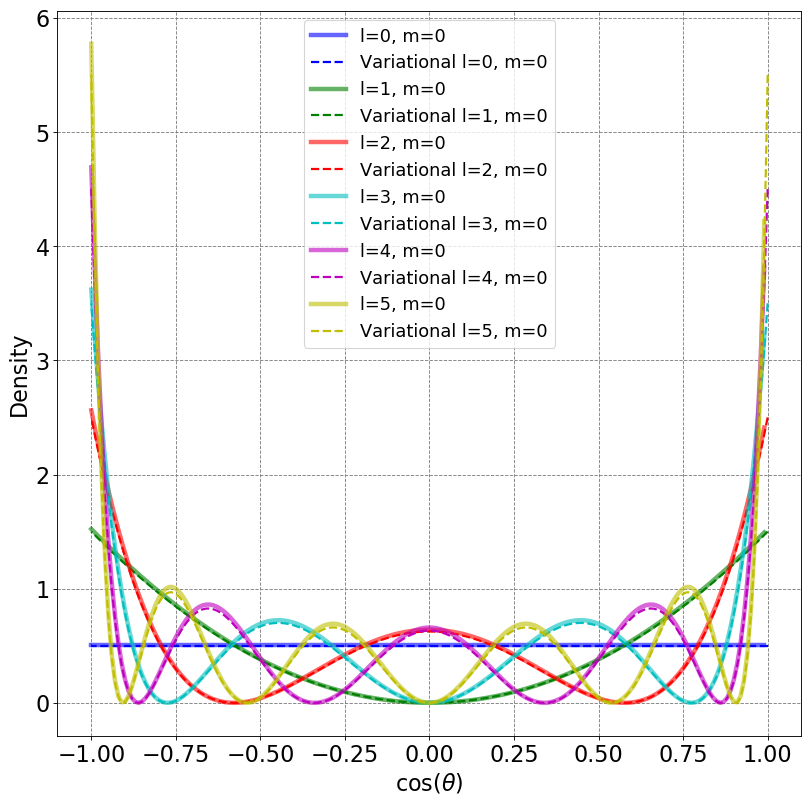

In [359]:
# cos basis function in theta
def cos_basis(theta,i):
    return np.cos(i*theta)
# H integrand
def cos_basis_H_integrand(theta,i,j):
    return j*np.cos(i*theta)*( np.cos(theta)*np.sin(j*theta) + j*np.sin(theta)*np.cos(j*theta) )

E, psi, theta, S, H = basis_rigid_rotator(20,cos_basis,cos_basis_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print("Energies:", E)
plot_rigid_rotator_densities(psi,theta,maxL=6)

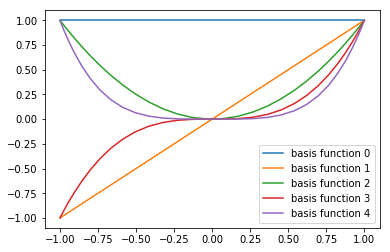

In [377]:
# cos basis function in theta
def cos_pow_i_basis(theta,i):
    return np.cos(theta)**i
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(5):
    label = "basis function " + str(i)
    plt.plot(np.cos(thetaVals),cos_pow_i_basis(thetaVals,i),label=label)
plt.legend()

[  0.           2.00007206   6.00000604  12.00000014  19.99991409
  29.99941527  42.00029496  56.00009422  71.99957204  89.99861699
 109.99974835 132.00224843 156.00151461 181.99883156 209.99829613
 240.00007679 272.00026814 306.00023198 341.99079154 380.02703464]


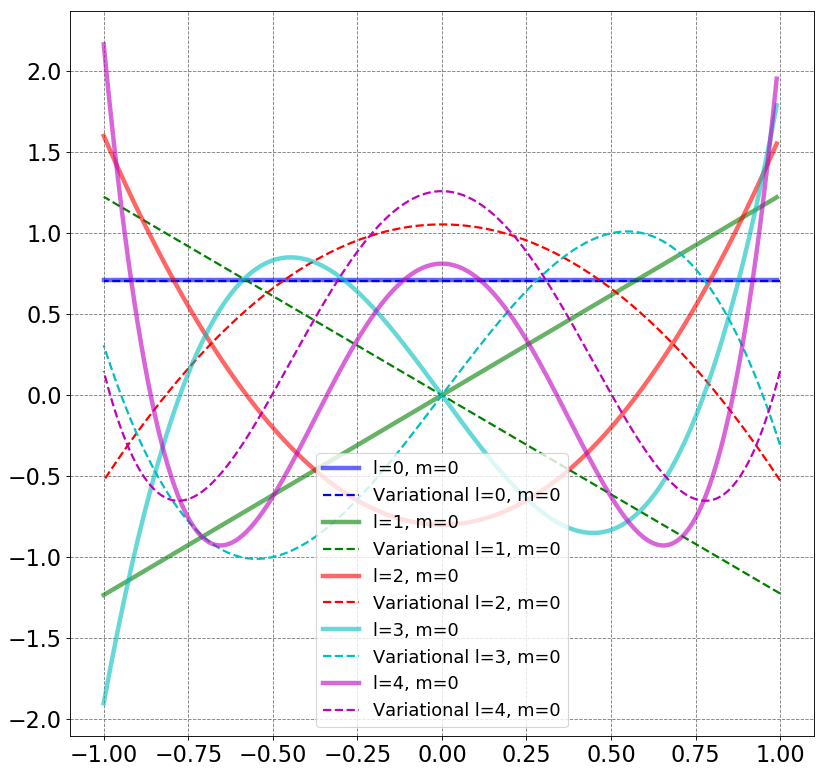

In [335]:
# H integrand
def cos_pow_i_H_integrand(theta,i,j):
    cosTheta = np.cos(theta)
    sinTheta = np.sin(theta)
    return j*( 2*sinTheta*cosTheta**(i+j) - (j-1)*sinTheta**3*cosTheta**(i+j-2) )

E, psi, theta, S, H = basis_rigid_rotator(20,cos_pow_i_basis,cos_pow_i_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print(E)
plot_rigid_rotator_wavefunctions(psi,theta)

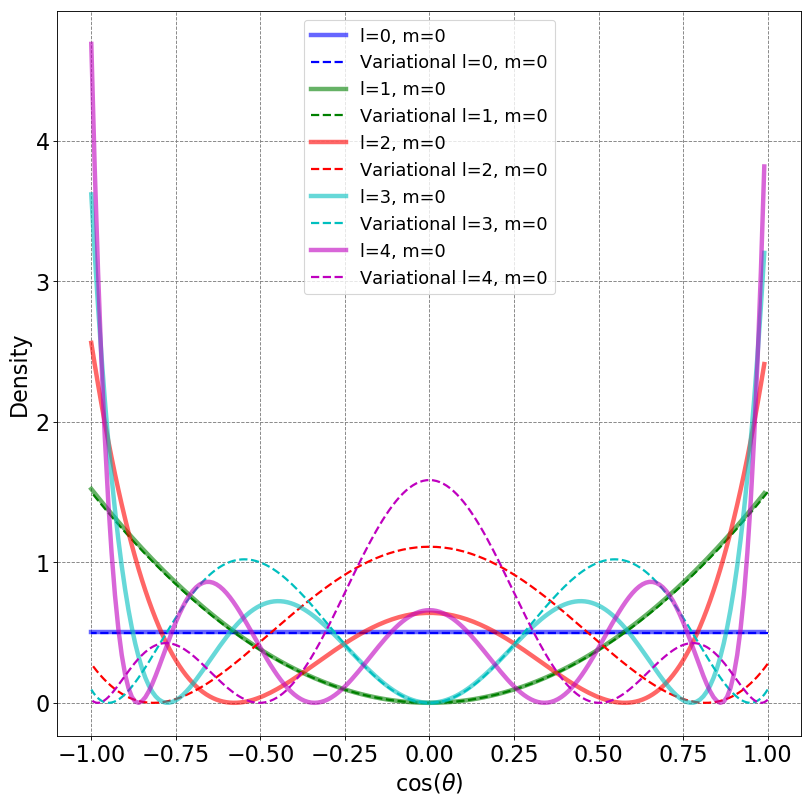

In [360]:
E, psi, theta, S, H = basis_rigid_rotator(10,cos_pow_i_basis,cos_pow_i_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
plot_rigid_rotator_densities(psi,theta)

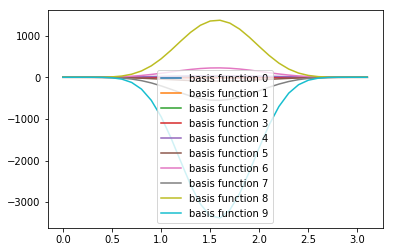

In [387]:
# polynomial basis functions in theta
def poly_basis(theta,i):
    return (theta)**(i)*(theta-np.pi)**(i)
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(10):
    label = "basis function " + str(i)
    plt.plot(thetaVals,poly_basis(thetaVals,i),label=label)
plt.legend()

[   0.            5.99976592   20.00035803   42.00076404   72.00207214
  110.09495074  161.77610252  267.20889835  605.60709635 3056.58953604]


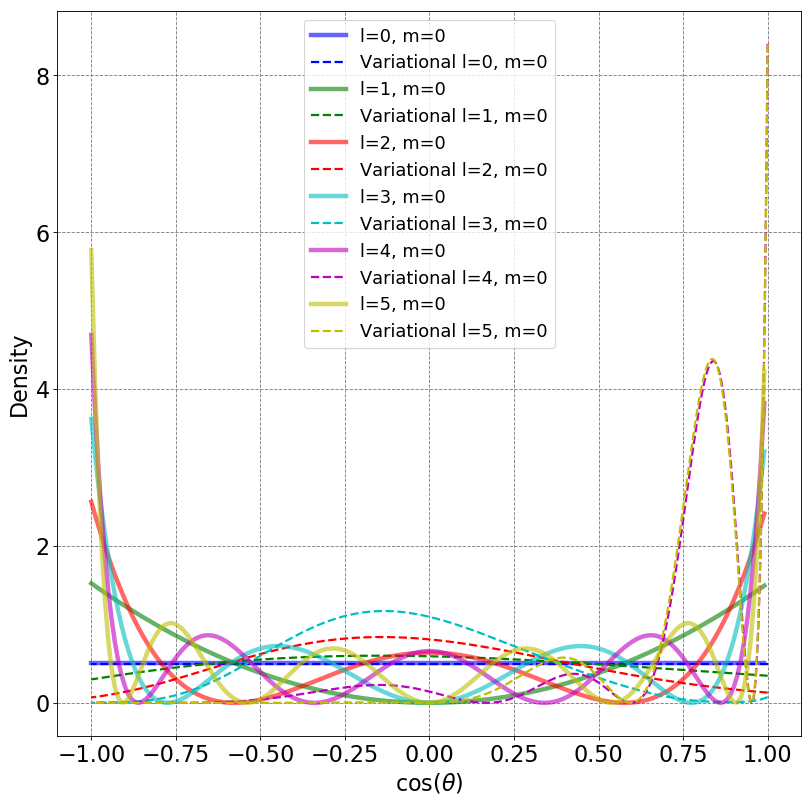

In [388]:
# H integrand
def poly_H_integrand(theta,i,j):
    thetaMpi = theta - np.pi
    return -j*theta**i*thetaMpi**i * (np.cos(theta) * (theta**(j-1)*thetaMpi**j + theta**j*thetaMpi**(j-1)) + np.sin(theta)*(2*j*theta**(j-1)*thetaMpi**(j-1)+(j-1)*(theta**(j-2)*thetaMpi**j+theta**j*thetaMpi**(j-2))))

E, psi, theta, S, H = basis_rigid_rotator(10,poly_basis,poly_H_integrand,thetaVals=np.arange(0,np.pi,0.01))
print(E)
plot_rigid_rotator_densities(psi,theta,maxL=6)

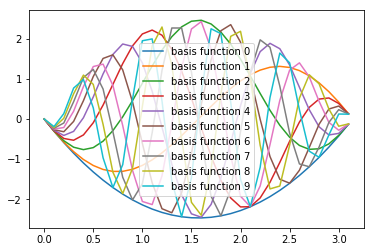

In [390]:
# polynomial basis functions in theta
def cos_poly_basis(theta,i):
    return theta*(theta-np.pi)*np.cos(i*theta)
thetaVals=np.arange(-0,np.pi,0.1)
for i in range(10):
    label = "basis function " + str(i)
    plt.plot(thetaVals,cos_poly_basis(thetaVals,i),label=label)
plt.legend()